## **Importing Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, mean_squared_log_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, LabelBinarizer, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor

from great_tables import GT, style ,exibble, from_column, loc
from colorama import Style, Fore

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [4]:
palette = ["d9ed92","b5e48c","99d98c","76c893","52b69a","34a0a4","168aad","1a759f","1e6091","184e77"]

config = {
    'SEED' : 42,
    'N_SPLITS': 5,
    'SUBMIT' : True,
    'USE_ORIGINAL': False
    
}

In [5]:
train = pd.read_csv('./data/train.csv')

In [6]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [7]:
train.shape

(1117957, 22)

In [8]:
train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [9]:
train.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,4.949230e+00,4.945239e+00,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,2.083324e+00,2.078141e+00,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [10]:
test = pd.read_csv('./data/test.csv')

In [11]:
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,4,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,7,4,3,2,6,4,6,8,4,5,5


In [12]:
test.shape

(745305, 21)

In [13]:
test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

In [14]:
test.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
count,7.453050e+05,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.00000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000
mean,1.490609e+06,4.915610,4.930288,4.960027,4.946084,4.938424,4.933524,4.958468,4.927651,4.945308,4.95062,4.947436,4.944003,4.957209,4.927620,4.930720,4.926062,4.926957,4.948424,4.940204,4.943918
std,2.151512e+05,2.056295,2.094117,2.071722,2.052602,2.081816,2.059243,2.089312,2.068110,2.073404,2.08175,2.081322,2.072335,2.088787,2.079006,2.083348,2.065638,2.073692,2.065891,2.079128,2.087387
min,1.117957e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.304283e+06,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.00000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000
50%,1.490609e+06,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,1.676935e+06,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,1.863261e+06,16.000000,17.000000,16.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,17.00000,16.000000,17.000000,17.000000,16.000000,16.000000,17.000000,19.000000,22.000000,16.000000,16.000000


In [15]:
original = pd.read_csv('./data/original.csv')

In [16]:
original.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,5,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,6,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,2,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,9,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,7,7,6,5,3,3,4,4,3,4,0.475


In [17]:
original.shape

(50000, 21)

In [18]:
original.isnull().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

## **FUNCTIONS**

**PrintINFO function**

In [19]:
def printInfo(df,train,test):
    print(f'{Style.BRIGHT}{Fore.YELLOW}SHAPE{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test:  {test.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original:  {df.shape}')
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nNULL VALUES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {test.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original: {df.isnull().any().any()}')    
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nDUPLICATES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {test.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original: {df.duplicated().any().any()}')

In [20]:
printInfo(original,train,test)

SHAPE
 train: (1117957, 22)
 test:  (745305, 21)
 original:  (50000, 21)

NULL VALUES
 train: False
 train: False
 original: False

DUPLICATES
 train: False
 train: False
 original: False


**Statistics function**

In [21]:
def Statistic(df: pd.DataFrame(), categoric = False):
    num_cols = list(df._get_numeric_data())
    cat_cols = list(df.drop(num_cols,axis=1))
    if categoric:
        desc = pd.DataFrame(index = list(df[cat_cols]))
        df = df[cat_cols]
    else:
        desc = pd.DataFrame(index = list(df[num_cols]))
        df = df[num_cols]
        desc['skew'] = df[num_cols].skew()
        
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100 
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)    

    desc = desc.round(2)
    return desc.reset_index().rename(columns={'index':'Column'}).sort_values(by=['type'])

In [22]:
Statistic(original)

,Column,skew,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
0,MonsoonIntensity,0.44,int64,50000,17,0.03,0,0.0,4.99,2.24,0.00,3.00,5.0,6.00,16.00
18,InadequatePlanning,0.46,int64,50000,17,0.03,0,0.0,4.99,2.23,0.00,3.00,5.0,6.00,16.00
17,WetlandLoss,0.44,int64,50000,19,0.04,0,0.0,5.01,2.23,0.00,3.00,5.0,6.00,22.00
16,PopulationScore,0.46,int64,50000,18,0.04,0,0.0,4.98,2.24,0.00,3.00,5.0,6.00,19.00
15,DeterioratingInfrastructure,0.45,int64,50000,18,0.04,0,0.0,4.99,2.23,0.00,3.00,5.0,6.00,17.00
14,Watersheds,0.47,int64,50000,17,0.03,0,0.0,4.98,2.23,0.00,3.00,5.0,6.00,16.00
13,Landslides,0.43,int64,50000,17,0.03,0,0.0,4.98,2.23,0.00,3.00,5.0,6.00,16.00
12,CoastalVulnerability,0.46,int64,50000,18,0.04,0,0.0,5.00,2.25,0.00,3.00,5.0,6.00,17.00
11,DrainageSystems,0.46,int64,50000,18,0.04,0,0.0,5.01,2.24,0.00,3.00,5.0,6.00,17.00
19,PoliticalFactors,0.45,int64,50000,17,0.03,0,0.0,4.99,2.25,0.00,3.00,5.0,6.00,16.00


**Min_Max_Unique function**

In [23]:
def min_max_unique(data_train, data_test):
    df = pd.DataFrame(index=data_train.columns)
    summary = {}
    
    for col in data_train.columns:
        if col in data_train and col in data_test:  # Check if column exists in both dataframes
            if pd.api.types.is_numeric_dtype(data_train[col]):  
                min_train = min(data_train[col])
                min_test = min(data_test[col])
                max_train = max(data_train[col])
                max_test = max(data_test[col])
                unique_train = len(data_train[col].unique())
                unique_test = len(data_test[col].unique())
                top5_train = sorted(data_train[col])[:5]
                top5_test = sorted(data_test[col])[:5]
            else:  
                min_train = min_test = max_train = max_test = None
                unique_train = len(data_train[col].unique())
                unique_test = len(data_test[col].unique())
                top5_train = top5_test = None
            summary[col] = [min_train, min_test, max_train, max_test, 
                            unique_train, unique_test]
        else:
            print(f"Column '{col}' not found in both data_train and data_test.")

    df = pd.DataFrame.from_dict(summary, orient='index', columns=['min_train', 'min_test', 'max_train', 'max_test', 
                                                                  'unique_train', 'unique_test'])\
        .reset_index().rename(columns={'index': 'columns'})
    return df


In [24]:
TARGET = 'FloodProbability'


**No.of Cols function**

In [25]:
def Number_of_columns(df):
    NUMERIC_COLS = [f for f in df._get_numeric_data() if f not in TARGET]
    CAT_COLS = list(df.drop(NUMERIC_COLS,axis=1))
    print(f'Numerical cols: {len(NUMERIC_COLS)}')
    print(f'Categorical cols: {len(CAT_COLS)}')

In [26]:
Number_of_columns(original)
Number_of_columns(train)
Number_of_columns(test)

Numerical cols: 20
Categorical cols: 1
Numerical cols: 21
Categorical cols: 1
Numerical cols: 21
Categorical cols: 0


In [27]:
min_max_unique(data_train=train, data_test=test)

Column 'FloodProbability' not found in both data_train and data_test.


,columns,min_train,min_test,max_train,max_test,unique_train,unique_test
0,id,0,1117957,1117956,1863261,1117957,745305
1,MonsoonIntensity,0,0,16,16,17,17
2,TopographyDrainage,0,0,18,17,19,18
3,RiverManagement,0,0,16,16,17,17
4,Deforestation,0,0,17,17,18,18
5,Urbanization,0,0,17,17,18,18
6,ClimateChange,0,0,17,17,18,18
7,DamsQuality,0,0,16,16,17,17
8,Siltation,0,0,16,16,17,17
9,AgriculturalPractices,0,0,16,16,17,17


In [28]:
min_max_unique(train.drop(TARGET,axis=1),test)

,columns,min_train,min_test,max_train,max_test,unique_train,unique_test
0,id,0,1117957,1117956,1863261,1117957,745305
1,MonsoonIntensity,0,0,16,16,17,17
2,TopographyDrainage,0,0,18,17,19,18
3,RiverManagement,0,0,16,16,17,17
4,Deforestation,0,0,17,17,18,18
5,Urbanization,0,0,17,17,18,18
6,ClimateChange,0,0,17,17,18,18
7,DamsQuality,0,0,16,16,17,17
8,Siltation,0,0,16,16,17,17
9,AgriculturalPractices,0,0,16,16,17,17


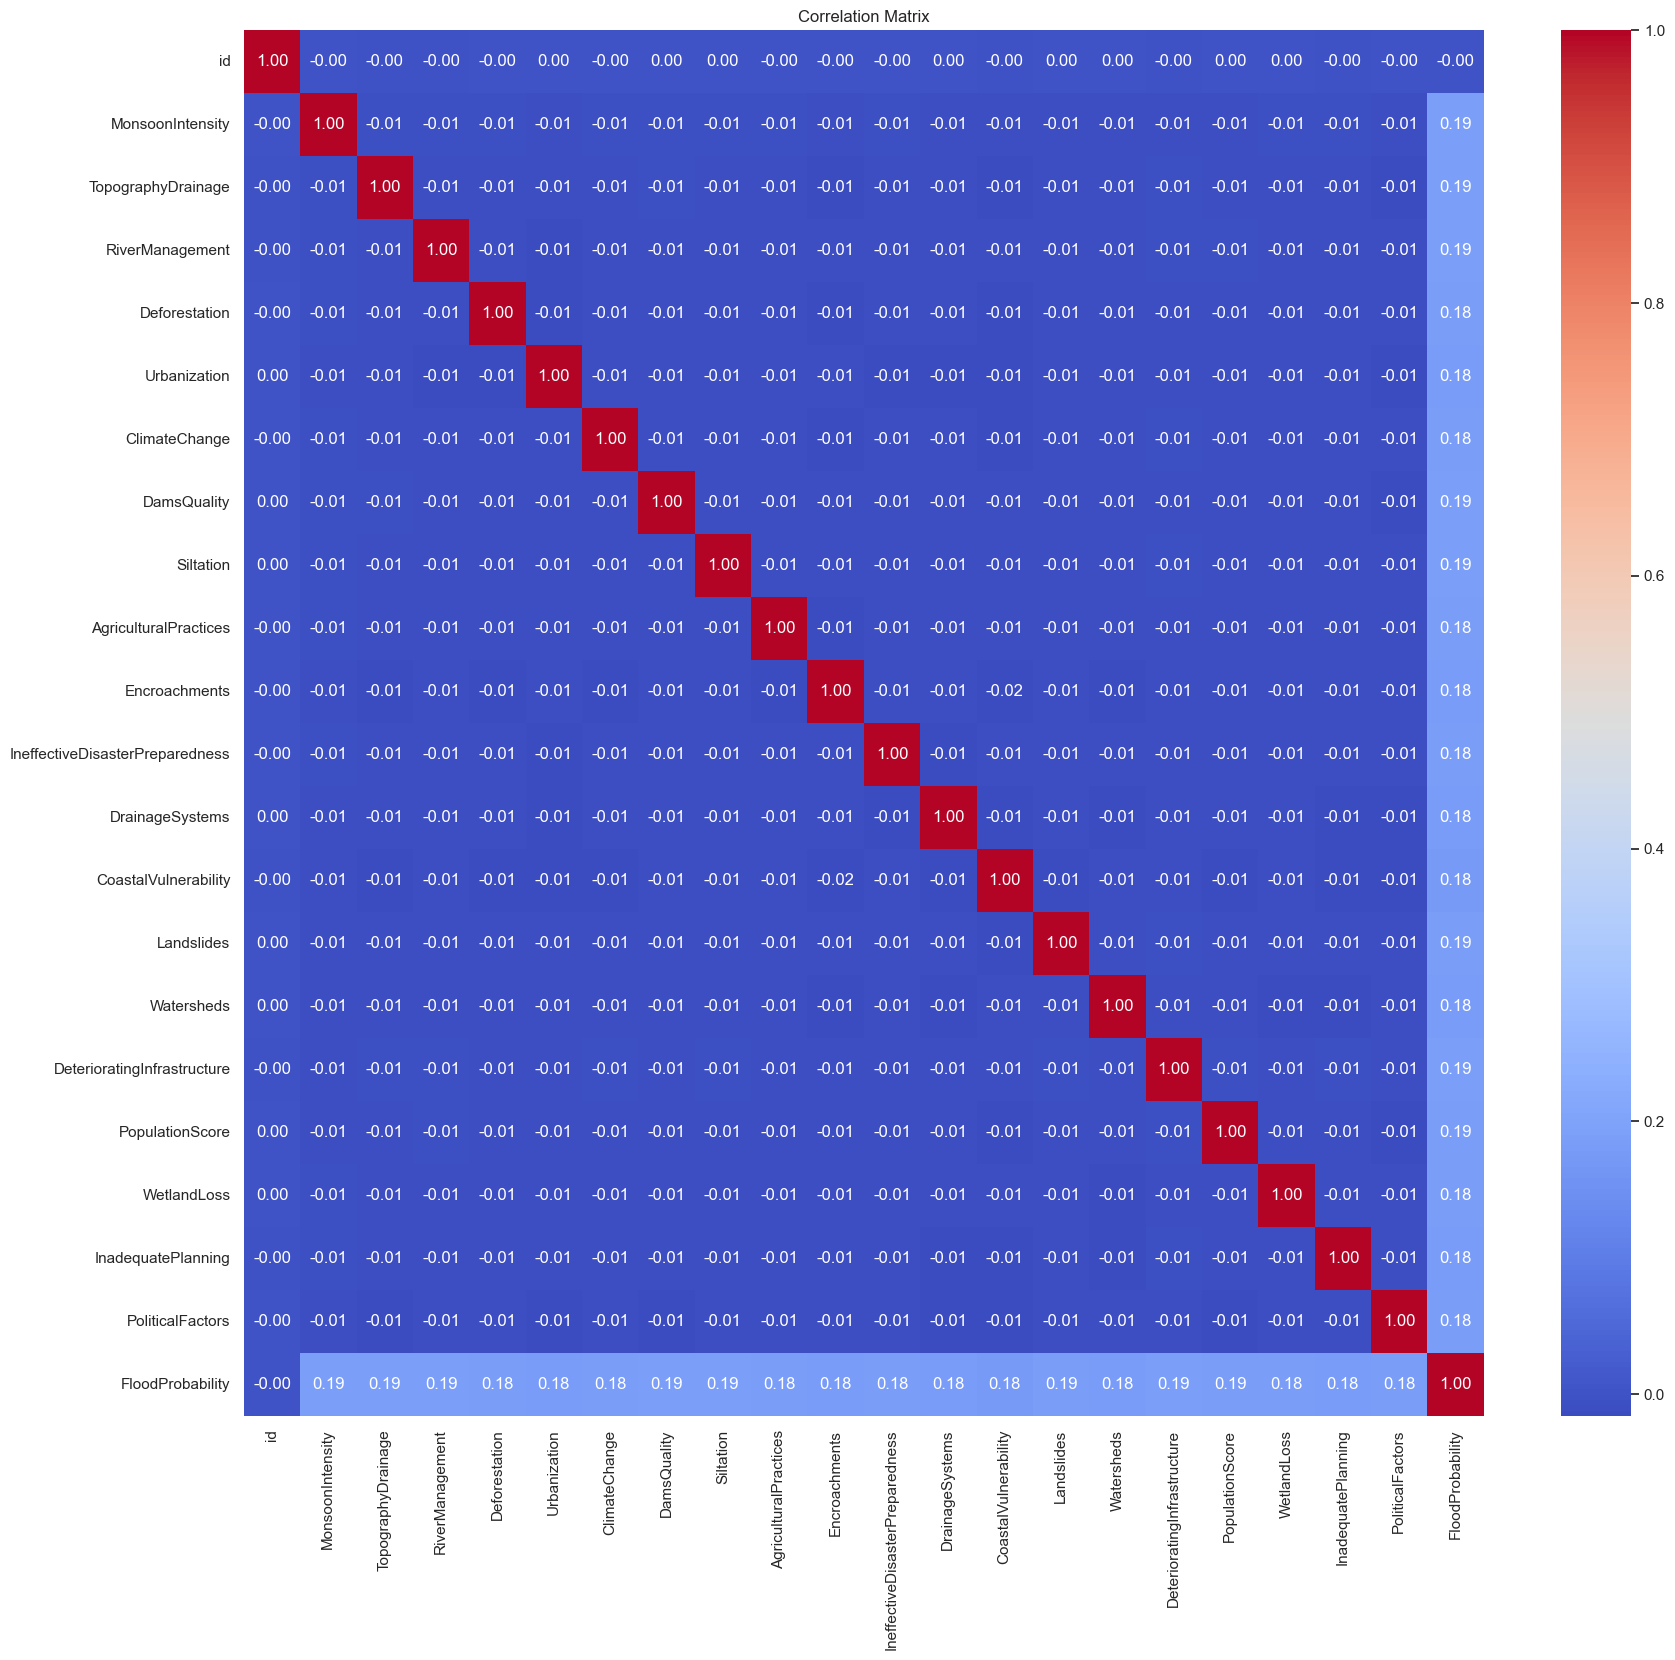

In [29]:
correlation_matrix = train.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

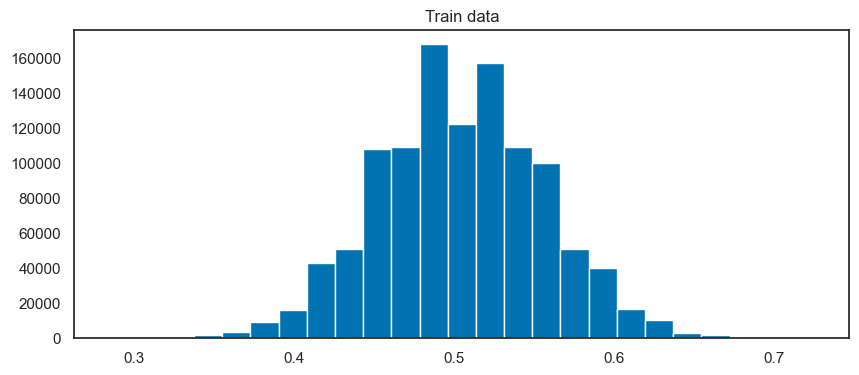

In [30]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=25)
plt.title("Train data")
plt.show()

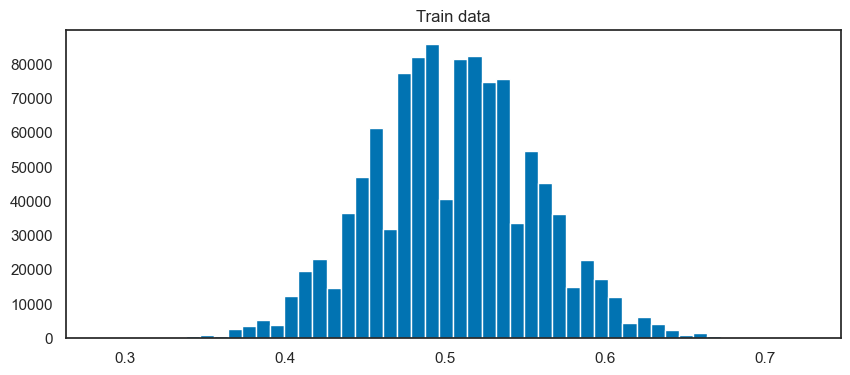

In [31]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=50)
plt.title("Train data")
plt.show()

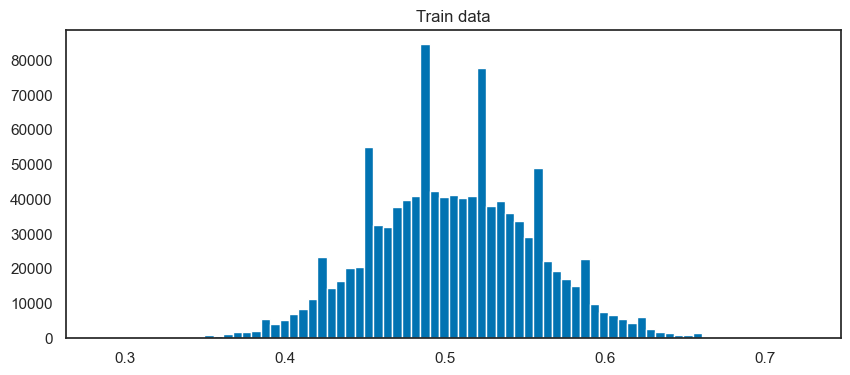

In [32]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=75)
plt.title("Train data")
plt.show()

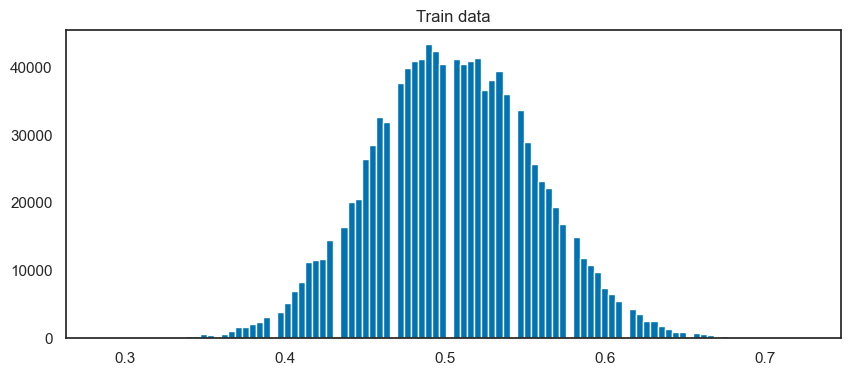

In [33]:
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=100)
plt.title("Train data")
plt.show()

In [34]:
stat = Statistic(train,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Train', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                             Column  skew  ...        75%         max
0                                id  0.00  ...  838467.00  1117956.00
19               InadequatePlanning  0.46  ...       6.00       16.00
18                      WetlandLoss  0.44  ...       6.00       19.00
17                  PopulationScore  0.45  ...       6.00       18.00
16      DeterioratingInfrastructure  0.44  ...       6.00       17.00
15                       Watersheds  0.45  ...       6.00       16.00
14                       Landslides  0.43  ...       6.00       16.00
13             CoastalVulnerability  0.44  ...       6.00       17.00
12                  DrainageSystems  0.44  ...       6.00       17.00
11  IneffectiveDisasterPreparedness  0.44  ...       6.00       16.00
10                    Encroachments  0.46  ...       6.00       18.00
9             AgriculturalPractices  0.42  ...       6.00       16.00
8                         Siltation  0.45  ...       6.00       16.00
7                       DamsQuality  0.44  ...       6.00       16.00
6                     ClimateChange  0.43  ...       6.00       17.00
5                      Urbanization  0.44  ...       6.00       17.00
4                     Deforestation  0.43  ...       6.00       17.00
3                   RiverManagement  0.43  ...       6.00       16.00
2                TopographyDrainage  0.46  ...       6.00       18.00
1                  MonsoonIntensity  0.44  ...       6.00       16.00
20                 PoliticalFactors  0.44  ...       6.00       16.00
21                 FloodProbability  0.05  ...       0.54        0.72

[22 rows x 15 columns], _body=<great_tables._gt_data.Body object at 0x000002A08580A870>, _boxhead=Boxhead([ColInfo(var='Column', type=<ColInfoTypeEnum.default: 1>, column_label='Column', column_align='left', column_width=None), ColInfo(var='skew', type=<ColInfoTypeEnum.default: 1>, column_label='skew', column_align='right', column_width=None), ColInfo(var='type', type=<ColInfoTypeEnum.default: 1>, column_label='type', column_align='right', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label='count', column_align='right', column_width=None), ColInfo(var='nunique', type=<ColInfoTypeEnum.default: 1>, column_label='nunique', column_align='right', column_width=None), ColInfo(var='%unique', type=<ColInfoTypeEnum.default: 1>, column_label='%unique', column_align='right', column_width=None), ColInfo(var='null', type=<ColInfoTypeEnum.default: 1>, column_label='null', column_align='right', column_width=None), ColInfo(var='%null', type=<ColInfoTypeEnum.default: 1>, column_label='%null', column_align='right', column_width=None), ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='mean', column_align='right', column_width=None), ColInfo(var='std', type=<ColInfoTypeEnum.default: 1>, column_label='std', column_align='right', column_width=None), ColInfo(var='min', type=<ColInfoTypeEnum.default: 1>, column_label='min', column_align='right', column_width=None), ColInfo(var='25%', type=<ColInfoTypeEnum.default: 1>, column_label='25%', column_align='right', column_width=None), ColInfo(var='50%', type=<ColInfoTypeEnum.default: 1>, column_label='50%', column_align='right', column_width=None), ColInfo(var='75%', type=<ColInfoTypeEnum.default: 1>, column_label='75%', column_align='right', column_width=None), ColInfo(var='max', type=<ColInfoTypeEnum.default: 1>, column_label='max', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=

In [35]:
stat = Statistic(test,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Test', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                             Column  skew  ...        75%        max
0                                id -0.00  ...  1676935.0  1863261.0
18                      WetlandLoss  0.43  ...        6.0       22.0
17                  PopulationScore  0.45  ...        6.0       19.0
16      DeterioratingInfrastructure  0.44  ...        6.0       17.0
15                       Watersheds  0.45  ...        6.0       16.0
14                       Landslides  0.42  ...        6.0       16.0
13             CoastalVulnerability  0.44  ...        6.0       17.0
12                  DrainageSystems  0.44  ...        6.0       17.0
11  IneffectiveDisasterPreparedness  0.45  ...        6.0       16.0
19               InadequatePlanning  0.45  ...        6.0       16.0
10                    Encroachments  0.45  ...        6.0       17.0
8                         Siltation  0.45  ...        6.0       16.0
7                       DamsQuality  0.44  ...        6.0       16.0
6                     ClimateChange  0.43  ...        6.0       17.0
5                      Urbanization  0.45  ...        6.0       17.0
4                     Deforestation  0.44  ...        6.0       17.0
3                   RiverManagement  0.41  ...        6.0       16.0
2                TopographyDrainage  0.46  ...        6.0       17.0
1                  MonsoonIntensity  0.44  ...        6.0       16.0
9             AgriculturalPractices  0.42  ...        6.0       16.0
20                 PoliticalFactors  0.44  ...        6.0       16.0

[21 rows x 15 columns], _body=<great_tables._gt_data.Body object at 0x000002A085856F60>, _boxhead=Boxhead([ColInfo(var='Column', type=<ColInfoTypeEnum.default: 1>, column_label='Column', column_align='left', column_width=None), ColInfo(var='skew', type=<ColInfoTypeEnum.default: 1>, column_label='skew', column_align='right', column_width=None), ColInfo(var='type', type=<ColInfoTypeEnum.default: 1>, column_label='type', column_align='right', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label='count', column_align='right', column_width=None), ColInfo(var='nunique', type=<ColInfoTypeEnum.default: 1>, column_label='nunique', column_align='right', column_width=None), ColInfo(var='%unique', type=<ColInfoTypeEnum.default: 1>, column_label='%unique', column_align='right', column_width=None), ColInfo(var='null', type=<ColInfoTypeEnum.default: 1>, column_label='null', column_align='right', column_width=None), ColInfo(var='%null', type=<ColInfoTypeEnum.default: 1>, column_label='%null', column_align='right', column_width=None), ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='mean', column_align='right', column_width=None), ColInfo(var='std', type=<ColInfoTypeEnum.default: 1>, column_label='std', column_align='right', column_width=None), ColInfo(var='min', type=<ColInfoTypeEnum.default: 1>, column_label='min', column_align='right', column_width=None), ColInfo(var='25%', type=<ColInfoTypeEnum.default: 1>, column_label='25%', column_align='right', column_width=None), ColInfo(var='50%', type=<ColInfoTypeEnum.default: 1>, column_label='50%', column_align='right', column_width=None), ColInfo(var='75%', type=<ColInfoTypeEnum.default: 1>, column_label='75%', column_align='right', column_width=None), ColInfo(var='max', type=<ColInfoTypeEnum.default: 1>, column_label='max', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), Row

In [36]:
s = min_max_unique(train.drop(TARGET,axis=1),test)
GT(s)\
    .tab_header(title='Min Max Uniques', subtitle='Train and Test datasets')\
    .data_color(columns=['columns'],palette=['lightgray','lightgray'])
    

GT(_tbl_data=                            columns  min_train  ...  unique_train  unique_test
0                                id          0  ...       1117957       745305
1                  MonsoonIntensity          0  ...            17           17
2                TopographyDrainage          0  ...            19           18
3                   RiverManagement          0  ...            17           17
4                     Deforestation          0  ...            18           18
5                      Urbanization          0  ...            18           18
6                     ClimateChange          0  ...            18           18
7                       DamsQuality          0  ...            17           17
8                         Siltation          0  ...            17           17
9             AgriculturalPractices          0  ...            17           17
10                    Encroachments          0  ...            19           18
11  IneffectiveDisasterPreparedness          0  ...            17           17
12                  DrainageSystems          0  ...            18           18
13             CoastalVulnerability          0  ...            18           18
14                       Landslides          0  ...            17           17
15                       Watersheds          0  ...            17           17
16      DeterioratingInfrastructure          0  ...            18           18
17                  PopulationScore          0  ...            19           20
18                      WetlandLoss          0  ...            20           20
19               InadequatePlanning          0  ...            17           17
20                 PoliticalFactors          0  ...            17           17

[21 rows x 7 columns], _body=<great_tables._gt_data.Body object at 0x000002A08439A390>, _boxhead=Boxhead([ColInfo(var='columns', type=<ColInfoTypeEnum.default: 1>, column_label='columns', column_align='left', column_width=None), ColInfo(var='min_train', type=<ColInfoTypeEnum.default: 1>, column_label='min_train', column_align='right', column_width=None), ColInfo(var='min_test', type=<ColInfoTypeEnum.default: 1>, column_label='min_test', column_align='right', column_width=None), ColInfo(var='max_train', type=<ColInfoTypeEnum.default: 1>, column_label='max_train', column_align='right', column_width=None), ColInfo(var='max_test', type=<ColInfoTypeEnum.default: 1>, column_label='max_test', column_align='right', column_width=None), ColInfo(var='unique_train', type=<ColInfoTypeEnum.default: 1>, column_label='unique_train', column_align='right', column_width=None), ColInfo(var='unique_test', type=<ColInfoTypeEnum.default: 1>, column_label='unique_test', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=8, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=9, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=10, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=11, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=12, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=13, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=14, group_id=None, rowname=None, group_label=None, built=False), RowInfo(row

In [37]:
def plot_correlation(df,label=''):
    corr = df._get_numeric_data().corr(method='spearman')
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)]=True
    fig, ax = plt.subplots(figsize=(25,17))
    sns.heatmap(data=corr, 
                mask=mask,annot=True,
                cmap='icefire',annot_kws={'size': 12, 'rotation': 45},
                ax=ax,linewidths=.5
                )
    ax.set_title(f'Correlation {label}',fontsize=25, fontweight='bold')

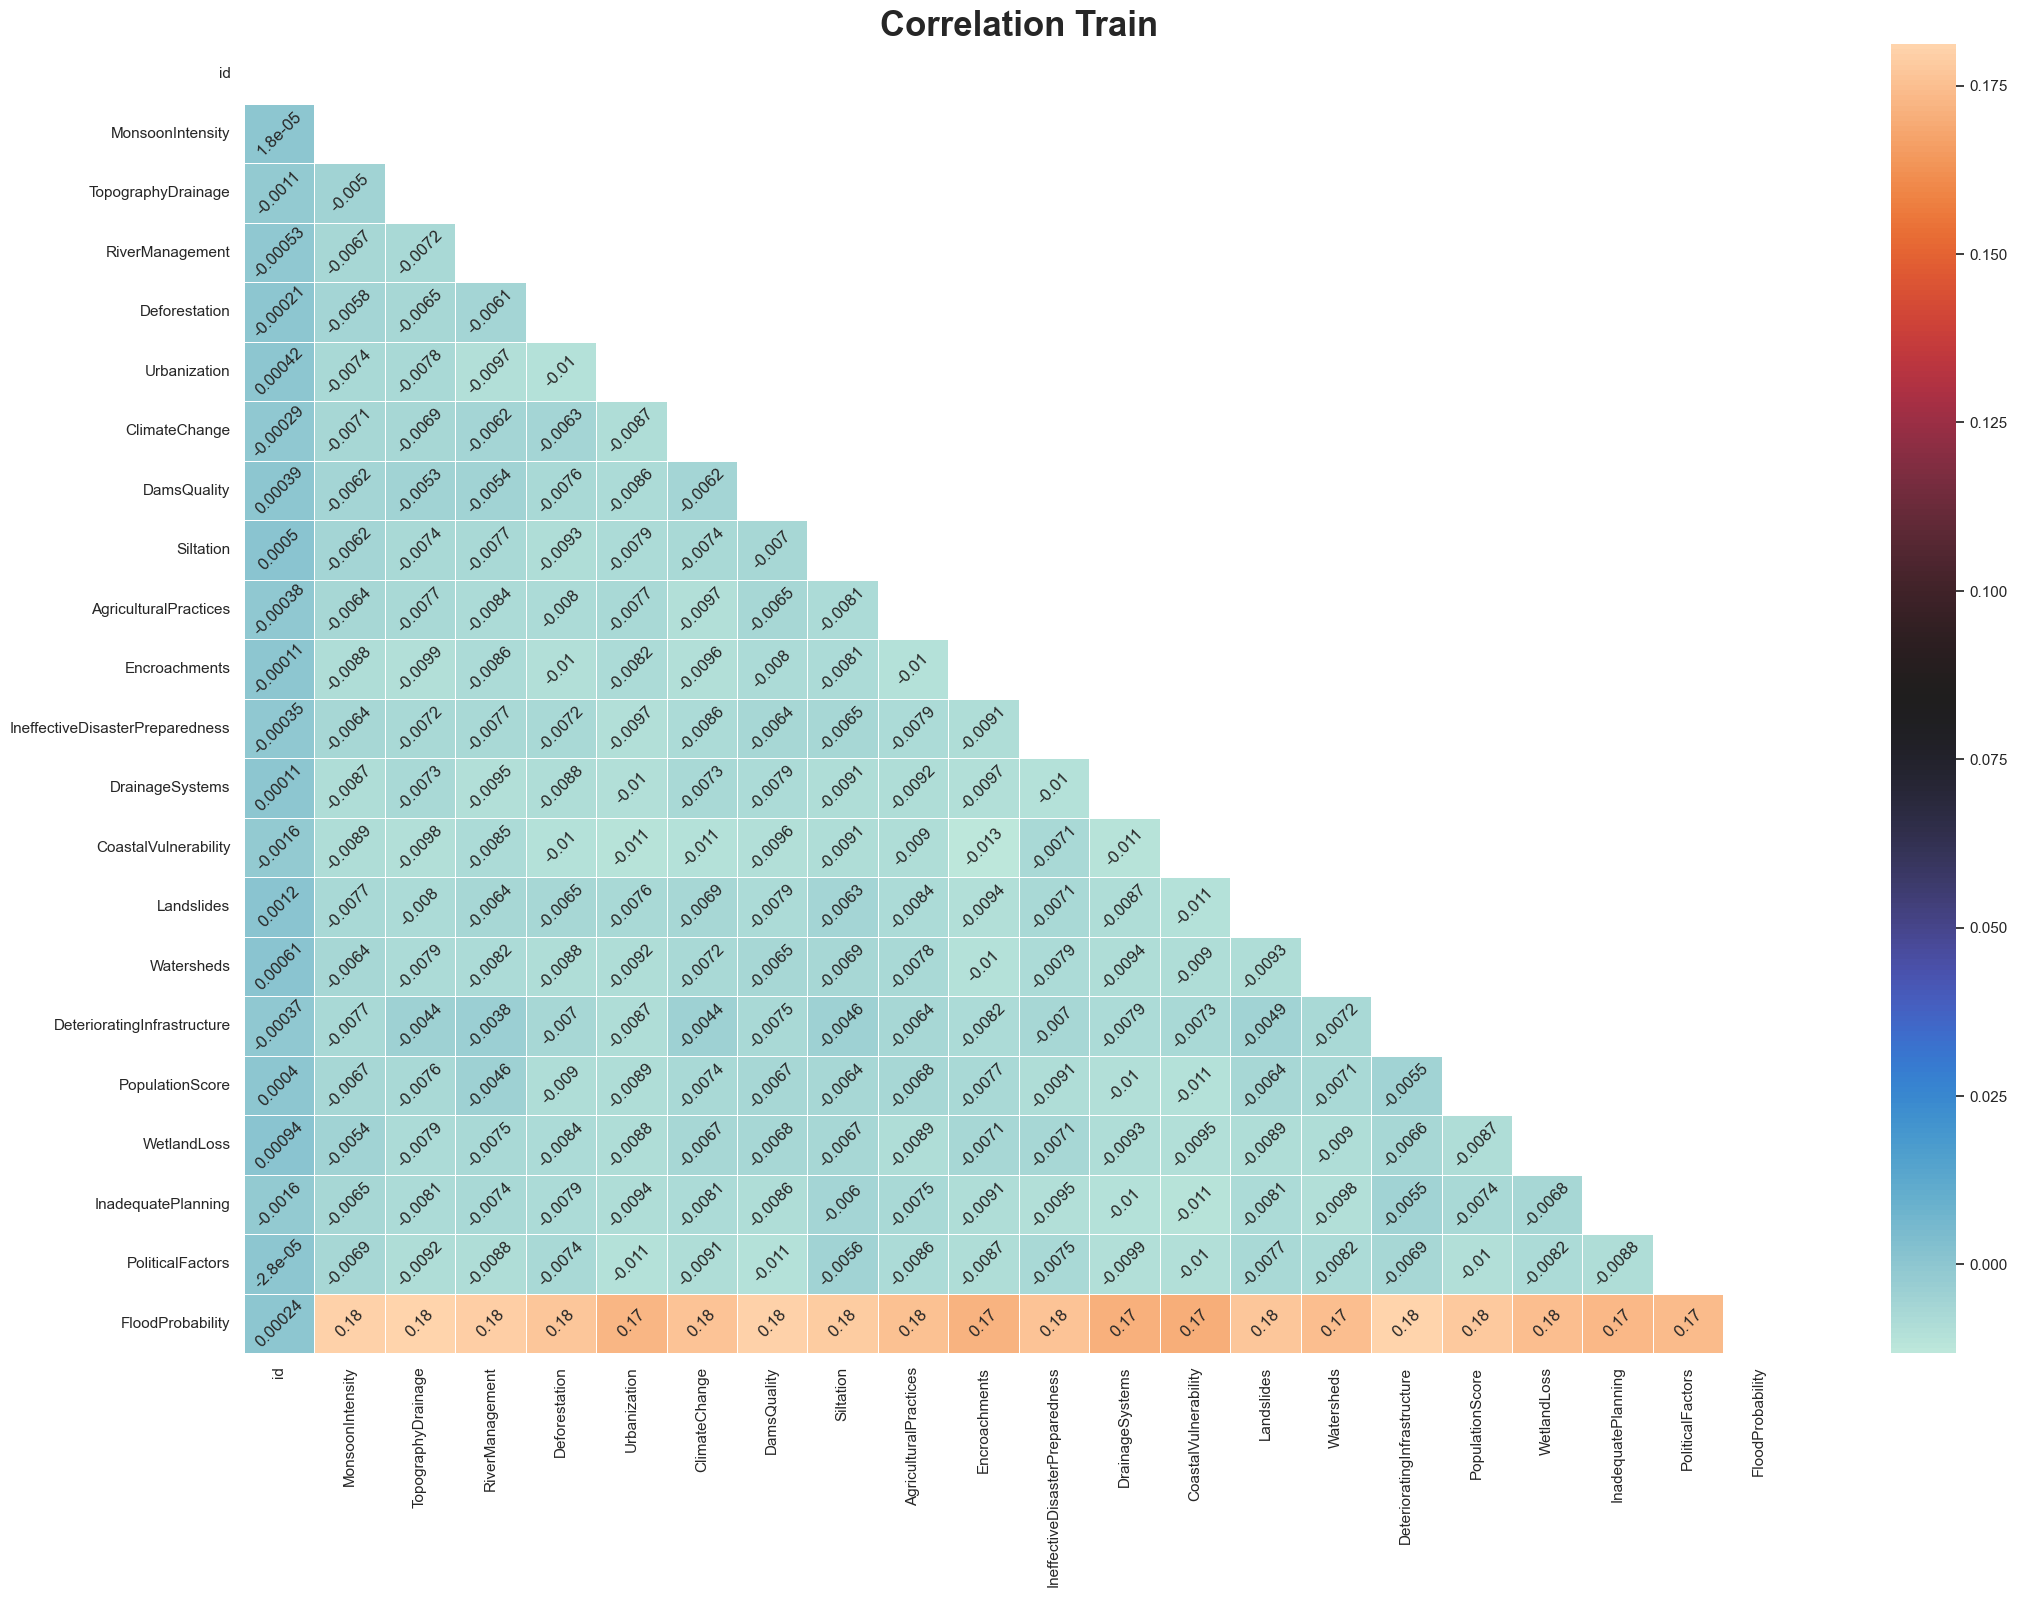

In [38]:
plot_correlation(train,'Train')

In [67]:
def plot_numerical_comparison(train, test, num_cols):
    # Use of more advanced artistic matplotlib interface (see the axes)
    fig, axes = plt.subplots(len(num_cols), 3, figsize=(16, len(num_cols) * 4),
                             gridspec_kw={'hspace': 0.35, 'wspace': 0.3,
                                          'width_ratios': [0.80, 0.20, 0.20]})

    for i, col in enumerate(num_cols):
        ax = axes[i, 0]
        sns.kdeplot(data=train[col], color='#456cf0', label='Train', linewidth=2.1, ax=ax)  # Train data
        sns.kdeplot(data=test[col], color='#ed7647', label='Test', linewidth=2.1, ax=ax)  # Test data
        ax.set_title(f"\n{col}", fontsize=9)
        ax.grid(visible=True, which='both', linestyle='--', color='lightgrey', linewidth=0.75)
        ax.set(xlabel='', ylabel='')

        ax = axes[i, 1]
        sns.boxplot(data=train, x=col, width=0.25, linewidth=0.90, fliersize=2.25, color='#456cf0', ax=ax)
        ax.set(xlabel='', ylabel='')
        ax.set_title("Train", fontsize=9)

        ax = axes[i, 2]
        sns.boxplot(data=test, x=col, width=0.25, linewidth=0.90, fliersize=2.25, color='#ed7647', ax=ax)
        ax.set(xlabel='', ylabel='')
        ax.set_title("Test", fontsize=9)

    plt.suptitle('\nDistribution comparison - numerical features', fontsize=12, y=0.89, x=0.57, fontweight='bold')
    plt.show()


In [68]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [69]:
num_cols

['id',
 'MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

In [70]:
num_cols.remove('id')
num_cols.remove('FloodProbability')

In [71]:
num_cols

['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors']

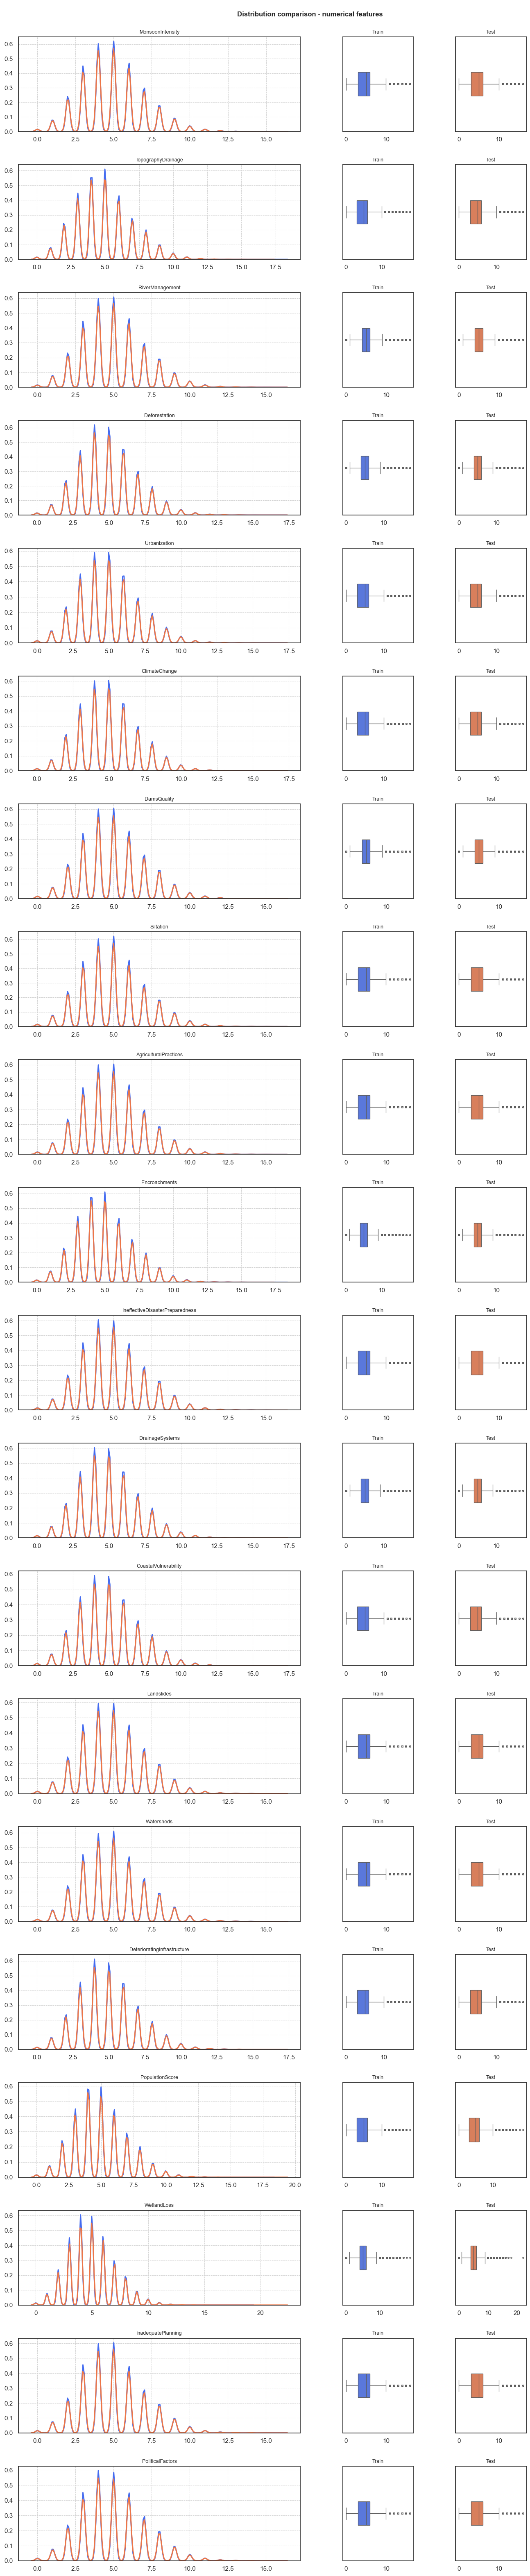

In [72]:
plot_numerical_comparison(train, test, num_cols)
